# Extended Graham scan algorithm

Use the cell below for all python code needed to realise the extended Graham scan algorithm (including any auxiliary data structures and functions you might need). The `extendedgrahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [5]:
import math

def changerange(theta):
    # The paper used the range of radians to be between [0, 2pi), but the math library uses [-pi, pi) 
    return theta if theta >= 0 else math.tau + theta

def ccw(p1, p2, p3):
    if p1 == None or p2 == None or p3 == None:
        return 0
    return (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0])

def pyth(p1, p2=[0,0]):
    # Calculates the distance between two points in the R^2 vector space using Pythagorous' 
    return sum([(p1[i] - p2[i]) ** 2 for i in range(len(p1))]) ** 0.5

def calcP(inputSet):
    # Finds the point P 
    P = inputSet[0]
    for point in inputSet:
        if point[1] < P[1] or (point[1] == P[1] and point[0] < P[0]):
            P = point
    return P

def polar(coordinates):
    return [pyth(coordinates), changerange(math.atan2(coordinates[1], coordinates[0]))]

def cartesianList(polarHull, P):
    return [cartesian(i, P=P) for i in polarHull]

def resetOrigin(P, inputSet):
    return [polar([i[0]-P[0], i[1]-P[1]]) for i in inputSet]

def cartesian(coordinates, P=[0,0]):
    return [round((coordinates[0] * math.cos(coordinates[1])) + P[0]), round((coordinates[0] * math.sin(coordinates[1])) + P[1])]

def merge(L,R):
    ret_array = []
    l_index, r_index = 0, 0
    while len(ret_array) < (len(L) + len(R)):
        if l_index == len(L):
            ret_array += R[r_index::]
            break
        elif r_index == len(R):
            ret_array += L[l_index::]
            break
        if L[l_index][1] < R[r_index][1]:
            ret_array.append(L[l_index])
            l_index += 1
        elif L[l_index][1] >= R[r_index][1]:
            ret_array.append(R[r_index])
            r_index += 1
    return ret_array

def msort(inputSet):
    # Sort the set of coordinates using merge sort
    return inputSet if len(inputSet) == 1 else merge(msort(inputSet[:len(inputSet)//2:]), msort(inputSet[len(inputSet)//2::]))
    
def maxr(inputSet, threshold=1e-8):
    # This function selects the polar coordinate with same angle as others but has the largest magnitude
    # A threshold default argument has been added to prevent floating point arithmetic errors
    polar, curtheta = [], -float("inf")
    for i in inputSet:
        if abs(i[1] - curtheta) < threshold:
            polar[-1][0] = max(i[0], polar[-1][0])
        else:
            polar.append(i)
            curtheta = i[1]
    return polar

def deletenomag(inputSet):
    # This function removes the polar coordinates with no magnitude
    return [i for i in inputSet if i[0] != 0]

def trace(inputSet, P):
    stack = [P, inputSet[0]]
    for point in inputSet:
        while len(stack) > 1 and ccw(stack[-2], stack[-1], point) < 0:
            _ = stack.pop()
        stack.append(point)
    return stack
 
def enclosedCoords(inputSet):
    #Remove points within inputSet that are enclosed by the NorthWest, NorthEast, SouthWest, SouthEast points
    xmax, xmin = [-float("inf"),0], [float("inf"),0]
    ymax, ymin = [0,-float("inf")], [0,float("inf")]
    for coord in inputSet:
        xmax = coord if max(coord[0],xmax[0]) == coord[0] else xmax
        xmin = coord if min(coord[0],xmin[0]) == coord[0] else xmin
        ymax = coord if max(coord[1],ymax[1]) == coord[1] else ymax
        ymin = coord if min(coord[1],ymin[1]) == coord[1] else ymin
    return [xmax,ymax,xmin,ymin]

def triangleArea(point1, point2,point3):
    #https://ncalculators.com/geometry/triangle-area-by-3-points.htm
    return abs(point1[0]*(point2[1]-point3[1]) + point2[0]*(point3[1]-point1[1]) + point3[0]*(point1[1]-point2[1])) /2

def notinRegion(point,enclose,area):
    total = [triangleArea(enclose[0],enclose[1],point), triangleArea(enclose[1],enclose[2],point), triangleArea(enclose[2],enclose[3],point), triangleArea(enclose[3],enclose[0],point)]
    return (sum(total) != area)

def wipePoints(inputSet):
    points = enclosedCoords(inputSet)
    enclosedArea = triangleArea(points[0],points[1],points[2]) + triangleArea(points[2],points[3],points[0])
    return [p for p in inputSet if notinRegion(p,points,enclosedArea)] + points

def extendedgrahamscan(inputSet):
    inputSet = wipePoints(inputSet)
    P = calcP(inputSet)
    polarSet = cartesianList(maxr(msort(deletenomag(resetOrigin(P, inputSet)))), P)
    return trace(polarSet, P)

Use the cell below for all python code needed to generate test data points (both random and those representing worst-case scenario).

In [6]:
import random

def alternate(inputSet):
    retArray = [[],[]]
    if len(inputSet) == 2:
        retArray[0] = [inputSet[0]]
        retArray[1] = [inputSet[1]]
    else:
        i = 0
        while i*2< len(inputSet):
            retArray[0].append(inputSet[i * 2])
            if (i * 2 + 1 < len(inputSet)):
                retArray[1].append(inputSet[i*2 + 1])
            i += 1
    return retArray

def genWorstDataSet(inputSet):
    if len(inputSet) == 1:
        return inputSet
    splitArray = alternate(inputSet)
    left = genWorstDataSet(splitArray[0])
    right = genWorstDataSet(splitArray[1])
    return (left + right)

def sortsecondIndex(arr):
    secondElement = [f[1] for f in arr]
    return sorted(range(len(arr)),key = lambda k : secondElement[k])

def changetoIndex(arr,indexArr):
    retArr = [None for i in range (len(arr))]
    x = 0
    for count,index in enumerate(indexArr):
        retArr[count] = arr[index]
    return retArr


#code for random data generation
def randGeneration(n, lb=0, ub=32767):
    return [[random.randint(lb, ub), random.randint(lb, ub)] for i in range(n)]

#code for worst case data generation
def randWorstGeneration(n):
    dataset = randGeneration(n)
    P = calcP(dataset)
    sortedIndex = sortsecondIndex(resetOrigin(P, dataset))
    sortedArray = changetoIndex(dataset,sortedIndex)
    return genWorstDataSet(sortedArray)


Use the cell below for all python code needed to test the `extendedgrahamscan()` function on the data generated above.

In [79]:
import timeit

#test code
def test(n, worstCase=False, repeats=1):
    timetaken = [0 for i in range(len(n))]
    for j in range(repeats):
        for i in n:
            data = randWorstGeneration(int(i)) if worstCase else randGeneration(int(i))
            start_time = timeit.default_timer()
            _ = extendedgrahamscan(data)
            timetaken[n.index(i)] += timeit.default_timer() - start_time
    return [i/repeats for i in timetaken]

n = [1e2, 5e2, 1e3, 5e3, 1e4, 1.5e4, 2e4]
r_timetaken, w_timetaken = test(n, repeats=5), test(n, worstCase = True,repeats=5)

In [3]:
import matplotlib.pyplot as plt
print (r_timetaken)
plt.plot(n, r_timetaken,color = 'green')
plt.plot(n,w_timetaken,color = 'blue')
plt.show()

NameError: name 'r_timetaken' is not defined

*Optional*: Feel free to use the code below on small datasets (e.g., N = 10) to visually inspect whether the algorithm has been implemented correctly. The fragment below assumes both `inputSet` and `outputSet` to be lists of 2D points, with each point being a list of 2 elements (e.g., `[[x1,y1], [x2,y2], ..., [x_k,y_k]]`)

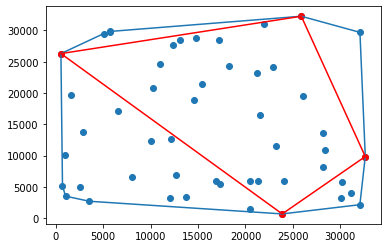

In [8]:
import matplotlib.pyplot as plt

#inputSet = [[1,1], [2,2], [3,3], [4,4], [1,4], [3,1], [1,5], [2,4], [3,5]]
#outputSet = [[1,1], [3,1], [4,4], [3,5], [1,5]]

inputSet = randGeneration(50)
outputSet = extendedgrahamscan(inputSet)
plt.figure()

#first do a scatter plot of the inputSet
input_xs, input_ys = zip(*inputSet)
plt.scatter(input_xs, input_ys)

bound = enclosedCoords(inputSet)
bound_xs, bound_ys = zip(*bound)
plt.scatter(bound_xs, bound_ys,color = "red")

#then do a polygon plot of the computed covex hull
outputSet.append(outputSet[0]) #first create a 'closed loop' by adding the first point at the end of the list
output_xs, output_ys = zip(*outputSet)
plt.plot(output_xs, output_ys) 

bound.append(bound[0])
output_xs, output_ys = zip(*bound)
plt.plot(output_xs, output_ys,color = "red") 


plt.show() 
